<a href="https://colab.research.google.com/github/sayakpaul/MIRNet-TFLite/blob/main/MIRNet_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows the TensorFlow Lite model conversion and inference processes for the **MIRNet** model as proposed by [Learning Enriched Features for Real Image Restoration and Enhancement](https://arxiv.org/pdf/2003.06792v2.pdf). This model is capable of enhancing low-light images upto a great extent. 

<p align="center">
<img src="https://github.com/soumik12345/MIRNet/raw/master/assets/lol_results.gif"</img><br>
<small><a href="https://github.com/soumik12345/MIRNet/blob/master/assets/lol_results.gif">Source</a></small>
</p>

Model training code and pre-trained weights are provided by **Soumik** through [this repository](https://github.com/soumik12345/MIRNet/). 

## Initial setup

In [ ]:
!git clone https://github.com/soumik12345/MIRNet
%cd MIRNet

/content/MIRNet


In [ ]:
!pip install -q wandb

     |████████████████████████████████| 1.8MB 13.3MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 133kB 60.1MB/s 
     |████████████████████████████████| 163kB 56.4MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 


In [ ]:
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
from mirnet.inference import Inferer
from mirnet.utils import download_dataset, plot_result

import tensorflow as tf
import numpy as np
print(tf.__version__)

2.3.0


## Download dataset and pre-trained weights

In [ ]:
download_dataset('LOL')

Downloading...
From: https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
To: /content/MIRNet/LOLdataset.zip
347MB [00:02, 157MB/s]


Unpacking Dataset
Done!!!


In [ ]:
inferer = Inferer()
inferer.download_weights('1sUlRD5MTRKKGxtqyYDpTv7T3jOW6aVAL')
inferer.build_model(
    num_rrg=3, num_mrb=2, channels=64,
    weights_path='low_light_weights_best.h5'
)
inferer.model.summary()

Downloading...
From: https://drive.google.com/uc?id=1sUlRD5MTRKKGxtqyYDpTv7T3jOW6aVAL
To: /content/MIRNet/low_light_weights_best.h5
148MB [00:01, 141MB/s]


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, None, None, 6 36928       conv2d_1[0][0]                   
_______________________________________________________________________________________

## TensorFlow Lite model conversion

In [ ]:
def convert_tflite(model=inferer.model, quant='dr', filename='mirnet_dr.tflite'):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if quant=='dr':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    elif quant=='fp16':
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
    
    tflite_model = converter.convert()
    open(filename, 'wb').write(tflite_model)
    print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0))

Here we are allowing the TensorFlow Lite model to handle dynamic shapes. If that is not desirable (GPU delegate does not support dynamic shapes yet) then follow [this notebook](TODO: update link). 

In [ ]:
convert_tflite(model=inferer.model, quant='dr', filename='mirnet_dr.tflite')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpzx9rv1a9/assets
Model size is 35.399612 MBs.


In [ ]:
convert_tflite(model=inferer.model, quant='fp16', filename='mirnet_fp16.tflite')

INFO:tensorflow:Assets written to: /tmp/tmp13lro89w/assets


INFO:tensorflow:Assets written to: /tmp/tmp13lro89w/assets


Model size is 69.924744 MBs.


In [ ]:
!ls -lh *.h5
!ls -lh *.tflite

-rw-r--r-- 1 root root 141M Dec  5 04:15 low_light_weights_best.h5
-rw-r--r-- 1 root root 36M Dec  5 04:16 mirnet_dr.tflite
-rw-r--r-- 1 root root 70M Dec  5 04:18 mirnet_fp16.tflite


The TensorFlow Lite model (`mirnet_dr.tflite`), because of its lower size, can be deployed to a mobile application. 

## TensorFlow Lite inference utilities

In [ ]:
LOW_LIGHT_IMGS = glob('./eval15/low/*')

MODEL_DICT = {
    "dr": "mirnet_dr.tflite",
    "fp16": "mirnet_fp16.tflite"
}

In [ ]:
def preprocess_image(image_path, image_resize_factor=1):
    original_image = Image.open(image_path)
    width, height = original_image.size
    preprocessed_image = original_image.resize(
        (
            width // image_resize_factor,
            height // image_resize_factor
        ),
        Image.ANTIALIAS)
    preprocessed_image = tf.keras.preprocessing.image.img_to_array(preprocessed_image)
    preprocessed_image = preprocessed_image.astype('float32') / 255.0
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    
    return original_image, preprocessed_image

In [ ]:
def infer_tflite(model_type, image):
    interpreter = tf.lite.Interpreter(model_path=MODEL_DICT[model_type])
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    interpreter.resize_tensor_input(0, [1, image.shape[1], image.shape[2], 3])
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()
    raw_prediction = interpreter.tensor(output_index)
    output_image = raw_prediction()

    output_image = output_image.squeeze() * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    return output_image

Some parts of the above two functions have been referred from [here](https://github.com/soumik12345/MIRNet/blob/master/mirnet/inference.py). 

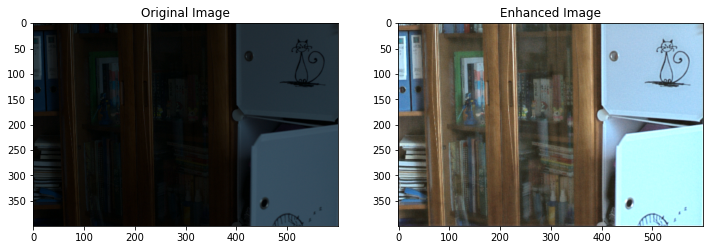

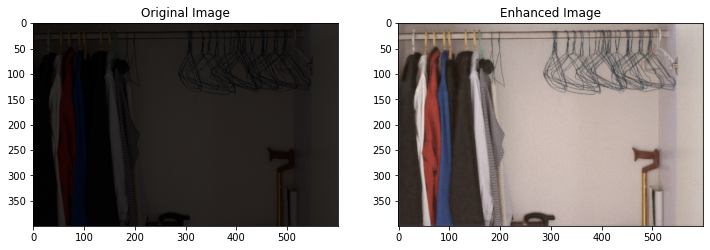

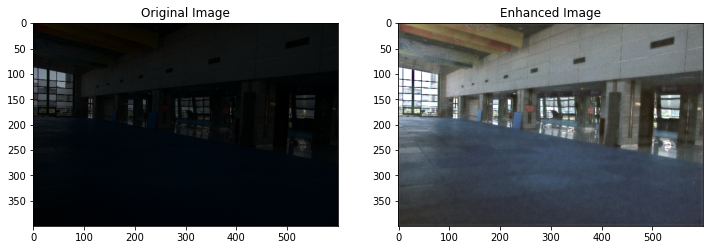

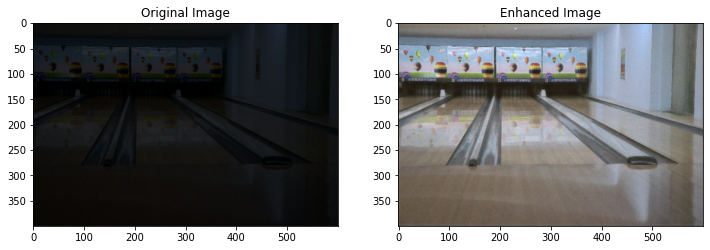

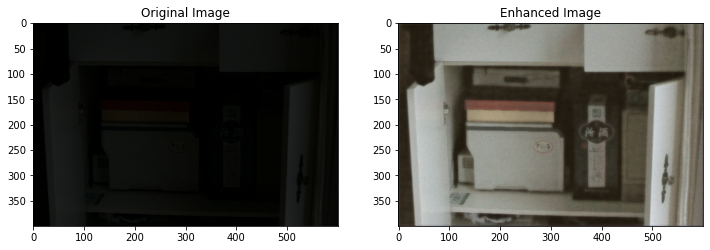

In [ ]:
#@title Run inference
model_type = "dr" #@param ["dr", "fp16"]

for image_path in LOW_LIGHT_IMGS[:5]:
    original_image, preprocessed_image = preprocess_image(image_path)
    output_image = infer_tflite(model_type, preprocessed_image)
    plot_result(Image.fromarray(np.uint8(original_image)), output_image)

## Compare results with the original model

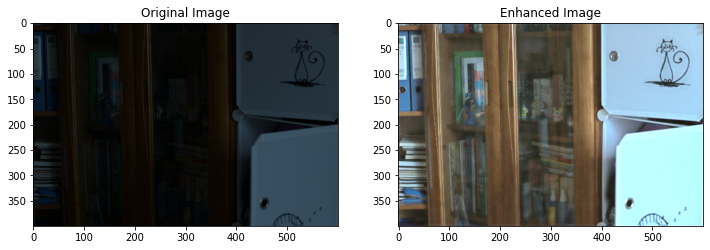

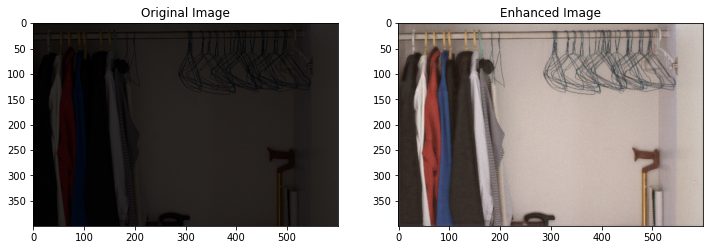

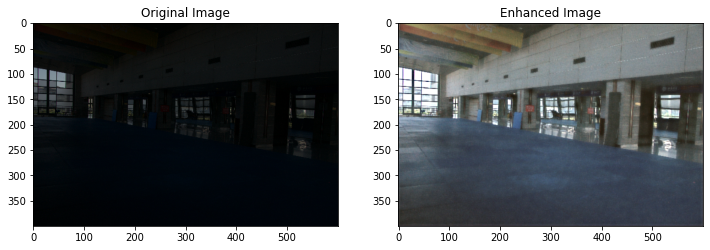

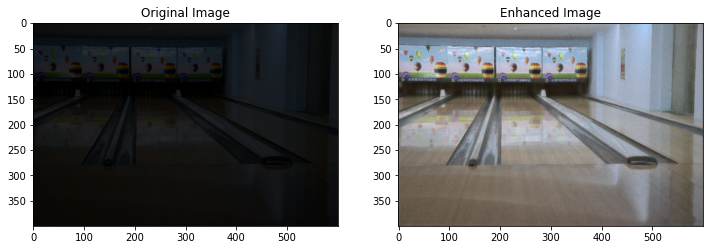

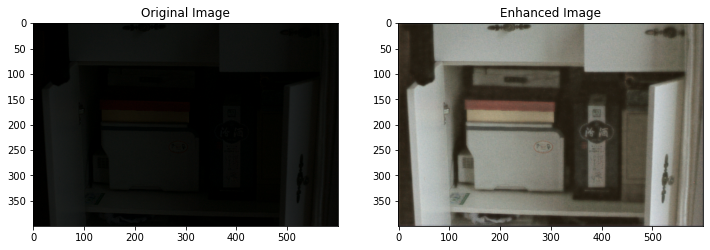

In [ ]:
for image_path in LOW_LIGHT_IMGS[:5]:
    original_image, output_image = inferer.infer(image_path)
    plot_result(original_image, output_image)